# Analyze Negotiation Results

This notebook loads a negotiation log CSV, ignores the `conversation_history` column, parses item valuations and final allocations, and computes per‑round metrics for later plotting:
- Agent 1 Utility
- Agent 2 Utility
- Current Welfare
- Max Welfare
- Welfare Efficiency (current/max)

Run the cells below and use the last cell to quickly verify values for the first round.

In [11]:
from __future__ import annotations
import pandas as pd
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import math
from IPython.display import display

pd.options.display.width = 120
pd.options.display.max_colwidth = 200


In [12]:
LOG_PATH = "logs/test boulware.csv"

In [13]:
def parse_items_data(items_str: str) -> Dict[str, Dict[str, float]]:
    """Parse the items_data JSON into a mapping {item_name: {'agent1': float, 'agent2': float}}."""
    if items_str is None or (isinstance(items_str, float) and math.isnan(items_str)) or items_str == "":
        return {}
    data = json.loads(items_str)
    items: Dict[str, Dict[str, float]] = {}
    for item in data:
        name = item.get("name")
        if not name:
            # Skip malformed entries
            continue
        a1_val = float(item.get("agent1_value", 0.0))
        a2_val = float(item.get("agent2_value", 0.0))
        items[name] = {"agent1": a1_val, "agent2": a2_val}
    return items

def parse_final_allocation(alloc_str: str) -> Dict[str, List[str]]:
    """Parse the final_allocation JSON into {agent1: [...], agent2: [...]}. Accepts either keys 'agent1'/'agent2' or 'agent1_items'/'agent2_items'."""
    if alloc_str is None or (isinstance(alloc_str, float) and math.isnan(alloc_str)) or alloc_str == "":
        return {"agent1": [], "agent2": []}
    data = json.loads(alloc_str)
    a1_list = data.get("agent1", data.get("agent1_items", [])) or []
    a2_list = data.get("agent2", data.get("agent2_items", [])) or []
    # Ensure lists
    a1_list = list(a1_list)
    a2_list = list(a2_list)
    return {"agent1": a1_list, "agent2": a2_list}

def compute_round_metrics(items_map: Dict[str, Dict[str, float]], final_alloc: Dict[str, List[str]]) -> Dict[str, float]:
    """Compute normalized utilities and welfare metrics for a round."""
    # Compute raw utilities
    a1_util = sum(items_map[i]["agent1"] for i in final_alloc.get("agent1", []) if i in items_map)
    a2_util = sum(items_map[i]["agent2"] for i in final_alloc.get("agent2", []) if i in items_map)
    # Compute max possible utility for each agent in this round
    a1_max = sum(v["agent1"] for v in items_map.values()) if items_map else 1.0
    a2_max = sum(v["agent2"] for v in items_map.values()) if items_map else 1.0
    # Normalize utilities to [0, 1] for this round
    a1_util_norm = a1_util / a1_max if a1_max else 0.0
    a2_util_norm = a2_util / a2_max if a2_max else 0.0
    current_welfare = a1_util + a2_util
    max_welfare = sum(max(v["agent1"], v["agent2"]) for v in items_map.values())
    welfare_eff = (current_welfare / max_welfare) if max_welfare and max_welfare > 0 else math.nan
    return {
        "agent1_utility": a1_util_norm,
        "agent2_utility": a2_util_norm,
        "current_welfare": current_welfare,
        "max_welfare": max_welfare,
        "welfare_efficiency": welfare_eff,
        "agent1_utility_raw": a1_util,
        "agent2_utility_raw": a2_util,
        "agent1_utility_max": a1_max,
        "agent2_utility_max": a2_max,
    }

def _compute_metrics_row(row: pd.Series) -> pd.Series:
    items_map = parse_items_data(row.get("items_data"))
    final_alloc = parse_final_allocation(row.get("final_allocation"))
    metrics = compute_round_metrics(items_map, final_alloc)
    return pd.Series(metrics)

def load_log_file(csv_path: Path | str) -> pd.DataFrame:
    """Load a single CSV log file, ignoring 'conversation_history', and compute round metrics. Returns a DataFrame with original columns (minus conversation_history) plus the metrics columns."""
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    # Read while ignoring the large conversation_history column
    df = pd.read_csv(
        path,
        engine="python",
        encoding="utf-8",
        usecols=lambda c: c != "conversation_history",
    )
    # Compute metrics per row
    metrics_df = df.apply(_compute_metrics_row, axis=1)
    out = pd.concat([df, metrics_df], axis=1)
    # Helpful type coercions for later plotting
    for col in ["round_number", "num_items", "turn_count", "starting_agent"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")
    return out


In [14]:
# Set your CSV path here. Defaults to one from the 'logs' folder if present.
default_csv = Path(LOG_PATH)
csv_path = default_csv if default_csv.exists() else None
if csv_path is None:
    print("Default CSV not found. Set 'csv_path' to your log file path, then run the next cell.")
else:
    print(f"Using CSV: {csv_path}")


Using CSV: logs\test boulware.csv


In [15]:
if csv_path is not None:
    metrics_df = load_log_file(csv_path)
    print(f"Loaded {len(metrics_df)} rounds from {csv_path.name}")
    # Display the first few rows (excluding very long columns)
    cols_to_show = [
        c for c in metrics_df.columns
        if c not in {"items_data", "final_allocation", "proposal_history"}
    ] + ["agent1_utility", "agent2_utility", "current_welfare", "max_welfare", "welfare_efficiency"]
    display(metrics_df[cols_to_show].head(3))


Loaded 100 rounds from test boulware.csv


,session_id,model_name,num_items,timestamp,date,agent1_type,agent2_type,boulware_initial_threshold,boulware_decrease_rate,boulware_min_threshold,...,welfare_efficiency,agent1_utility_raw,agent2_utility_raw,agent1_utility_max,agent2_utility_max,agent1_utility,agent2_utility,current_welfare,max_welfare,welfare_efficiency
0,gpt-oss_20b_default_vs_boulware_4_20250930_162737,gpt-oss_20b_default_vs_boulware,4,2025-09-30T16:28:39.675408,2025-09-30,default,boulware,0.85,NaN,0.5,...,0.840000,0.5,1.6,0.9,2.5,0.555556,0.640000,2.1,2.5,0.840000
1,gpt-oss_20b_default_vs_boulware_4_20250930_162737,gpt-oss_20b_default_vs_boulware,4,2025-09-30T16:29:34.518687,2025-09-30,default,boulware,0.85,NaN,0.5,...,0.615385,0.1,0.7,1.3,0.8,0.076923,0.875000,0.8,1.3,0.615385
2,gpt-oss_20b_default_vs_boulware_4_20250930_162737,gpt-oss_20b_default_vs_boulware,4,2025-09-30T16:29:48.098875,2025-09-30,default,boulware,0.85,NaN,0.5,...,0.972222,1.7,1.8,2.8,1.9,0.607143,0.947368,3.5,3.6,0.972222


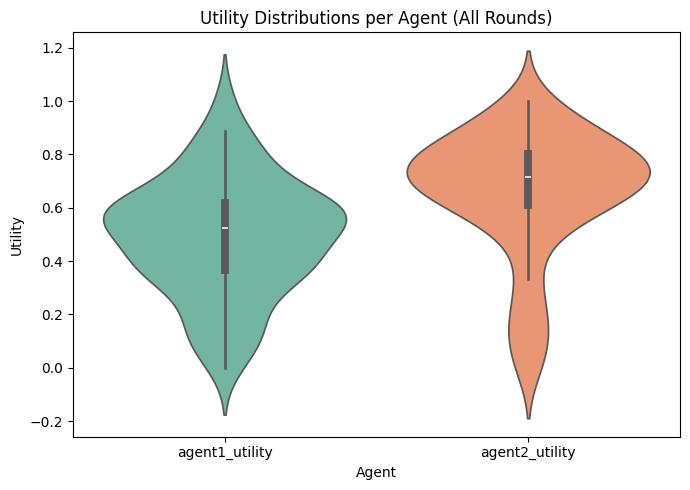

In [16]:
# Utility Distributions per Agent (Violin Plot)
import matplotlib.pyplot as plt
import seaborn as sns

if 'metrics_df' in globals() and not metrics_df.empty:
    # Prepare data for plotting
    plot_df = metrics_df[['agent1_utility', 'agent2_utility']].copy()
    plot_df = plot_df.melt(var_name='Agent', value_name='Utility')

    plt.figure(figsize=(7, 5))
    sns.violinplot(x='Agent', y='Utility', hue='Agent', data=plot_df, inner='box', palette='Set2', legend=False)
    plt.title('Utility Distributions per Agent (All Rounds)')
    plt.xlabel('Agent')
    plt.ylabel('Utility')
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

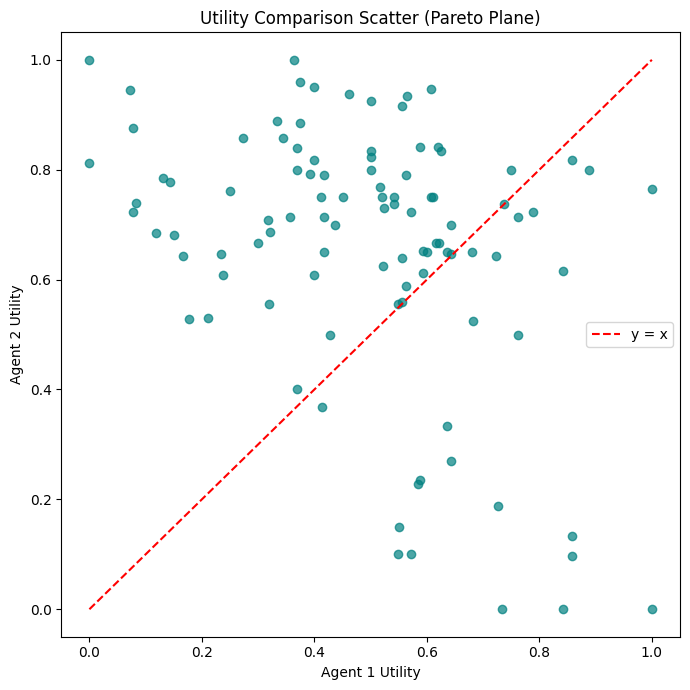

In [17]:
# Utility Comparison Scatter (Pareto Plane)
import matplotlib.pyplot as plt

if 'metrics_df' in globals() and not metrics_df.empty:
    plt.figure(figsize=(7, 7))
    plt.scatter(metrics_df['agent1_utility'], metrics_df['agent2_utility'], alpha=0.7, color='teal')
    # Add y=x reference line
    min_util = min(metrics_df['agent1_utility'].min(), metrics_df['agent2_utility'].min())
    max_util = max(metrics_df['agent1_utility'].max(), metrics_df['agent2_utility'].max())
    plt.plot([min_util, max_util], [min_util, max_util], 'r--', label='y = x')
    plt.xlabel('Agent 1 Utility')
    plt.ylabel('Agent 2 Utility')
    plt.title('Utility Comparison Scatter (Pareto Plane)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

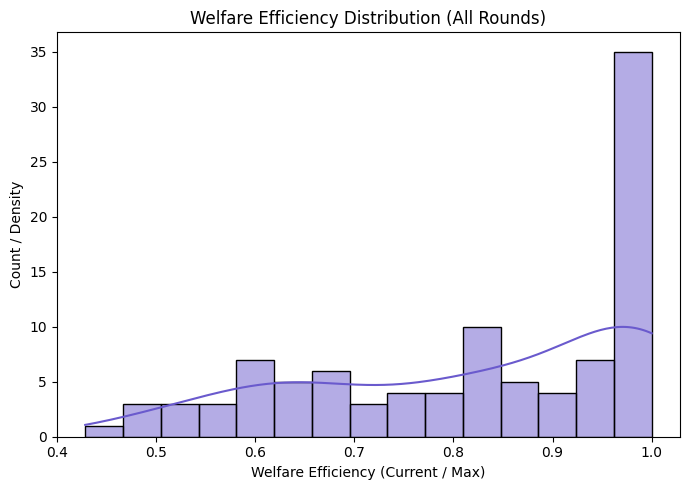

In [18]:
# Welfare Efficiency Distribution (Histogram/KDE)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'metrics_df' in globals() and not metrics_df.empty:
    # Copy and prep data
    eff_vals = metrics_df['welfare_efficiency'].dropna()
    plt.figure(figsize=(7, 5))
    sns.histplot(eff_vals, kde=True, bins=15, color='slateblue', edgecolor='black')
    plt.title('Welfare Efficiency Distribution (All Rounds)')
    plt.xlabel('Welfare Efficiency (Current / Max)')
    plt.ylabel('Count / Density')
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

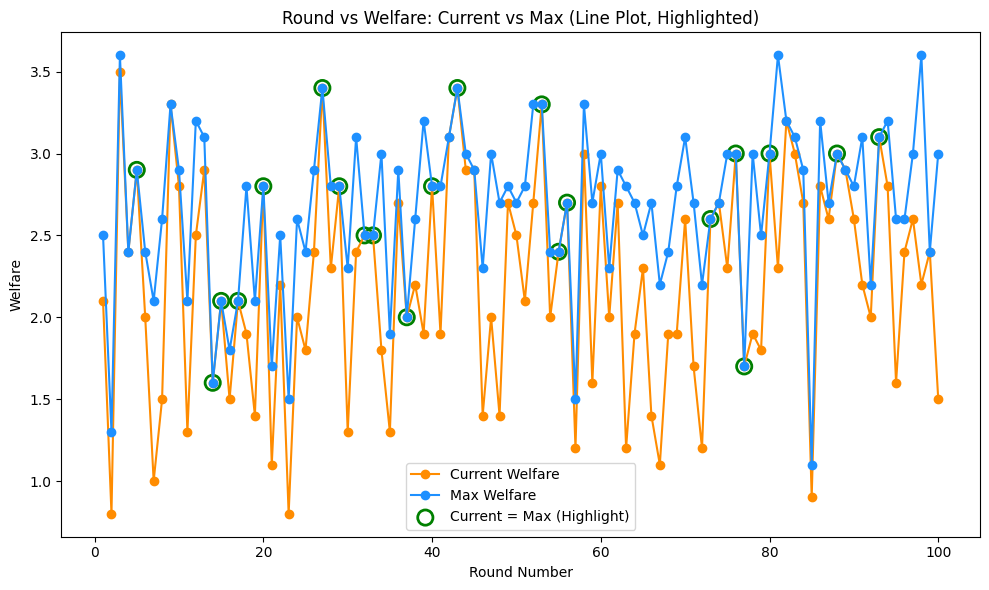

In [19]:
# Line Plot: Round vs Welfare (Current & Max) with Highlighted Max Matches
import matplotlib.pyplot as plt

if 'metrics_df' in globals() and not metrics_df.empty:
    plot_df = metrics_df.copy()
    plt.figure(figsize=(10, 6))
    # Plot lines
    plt.plot(plot_df['round_number'], plot_df['current_welfare'], marker='o', color='darkorange', label='Current Welfare')
    plt.plot(plot_df['round_number'], plot_df['max_welfare'], marker='o', color='dodgerblue', label='Max Welfare')
    # Highlight points where current welfare == max welfare
    matches = plot_df[plot_df['current_welfare'] == plot_df['max_welfare']]
    plt.scatter(matches['round_number'], matches['current_welfare'], facecolors='none', edgecolors='green', s=120, linewidths=2, label='Current = Max (Highlight)')
    plt.xlabel('Round Number')
    plt.ylabel('Welfare')
    plt.title('Round vs Welfare: Current vs Max (Line Plot, Highlighted)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

Using current loaded Boulware log: test boulware.csv


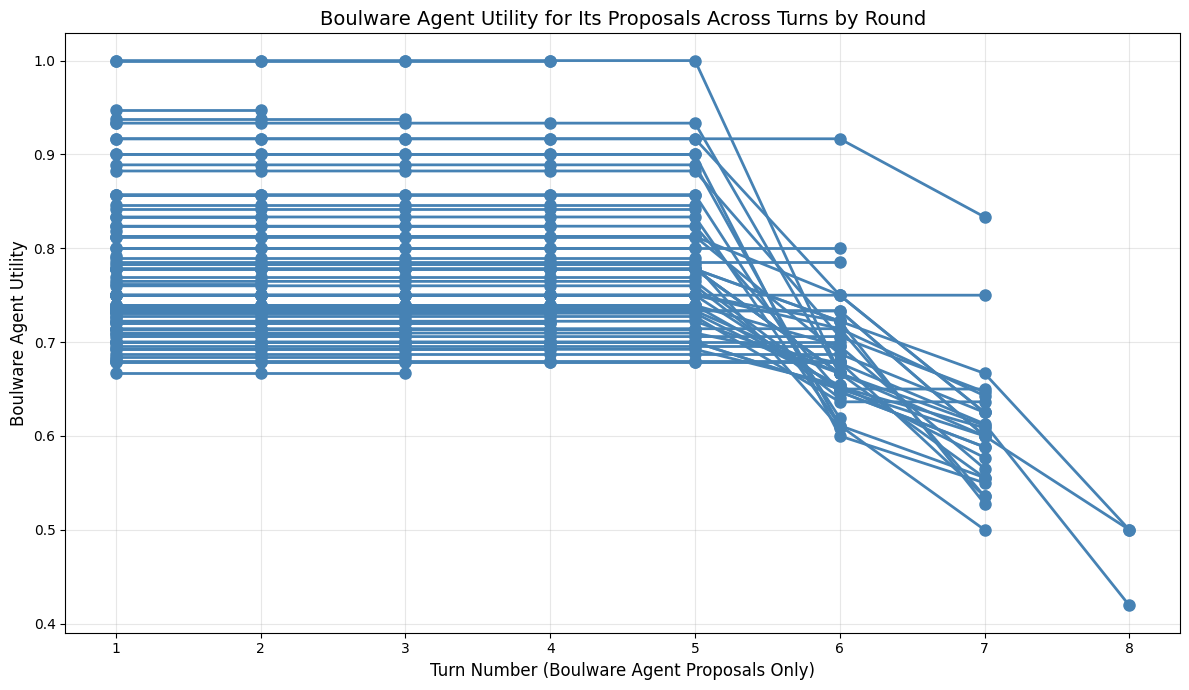

Successfully plotted 91 rounds with Boulware agent proposals


In [20]:
# Boulware Agent Proposal Utilities Across Turns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re
import os

# Find Boulware agent logs
if 'metrics_df' in globals() and not metrics_df.empty:
    # Check if this is a Boulware agent log or set manually
    csv_path_str = LOG_PATH
    log_dir = Path(LOG_PATH)
    boulware_csv = None
    
    # Try to find a Boulware log file if current one isn't
    if "boulware" not in csv_path_str.lower():
        # Look for Boulware logs in the logs directory
        if log_dir.exists():
            for file in log_dir.glob("*boulware*.csv"):
                boulware_csv = file
                break
        
        if boulware_csv:
            print(f"Found Boulware log: {boulware_csv.name}")
            # Use pandas to read the CSV file directly to include conversation_history
            boulware_df = pd.read_csv(boulware_csv)
            # Then calculate metrics
            metrics_df_temp = boulware_df.apply(_compute_metrics_row, axis=1)
            boulware_df = pd.concat([boulware_df, metrics_df_temp], axis=1)
        else:
            print("No Boulware agent logs found. Please specify a Boulware log file path.")
            boulware_df = None
    else:
        # Current loaded file is a Boulware log
        # We need to reload to get conversation_history
        boulware_df = pd.read_csv(csv_path)
        # Then calculate metrics
        metrics_df_temp = boulware_df.apply(_compute_metrics_row, axis=1)
        boulware_df = pd.concat([boulware_df, metrics_df_temp], axis=1)
        print(f"Using current loaded Boulware log: {csv_path.name}")
    
    if boulware_df is not None:
        # Extract Boulware specific data
        boulware_data = boulware_df[boulware_df['agent2_type'] == 'boulware'].copy()
        
        if not boulware_data.empty:
            # Create figure for plotting
            plt.figure(figsize=(12, 7))
            
            # Use the proposal_history directly since it's more structured
            # Get unique rounds
            rounds = boulware_data['round_number'].unique()
            
            # For each round, analyze the proposals and plot the utility
            round_count = 0
            for i, round_num in enumerate(rounds):
                round_row = boulware_data[boulware_data['round_number'] == round_num].iloc[0]
                
                # Parse the items data to calculate utility
                items_map = parse_items_data(round_row['items_data'])
                
                # Try to get proposal history
                try:
                    proposal_history = round_row['proposal_history']
                    if pd.isna(proposal_history) or not proposal_history or proposal_history == '[]':
                        continue
                    
                    # Parse the proposal history
                    proposals_data = json.loads(proposal_history)
                    
                    # Filter for agent 2's proposals
                    agent2_proposals = [p for p in proposals_data if p.get('agent_num') == 2]
                    
                    if not agent2_proposals:
                        continue
                    
                    # Calculate utilities for each proposal
                    turn_utilities = []
                    for turn_idx, proposal in enumerate(agent2_proposals):
                        proposal_data = proposal.get('proposal', {})
                        
                        # Create allocation dictionary
                        allocation = {
                            "agent1": proposal_data.get('agent1_items', []),
                            "agent2": proposal_data.get('agent2_items', [])
                        }
                        
                        # Calculate the utility for agent2 (Boulware)
                        metrics = compute_round_metrics(items_map, allocation)
                        turn_utilities.append((turn_idx + 1, metrics['agent2_utility']))
                    
                    # Plot the utilities for this round
                    if turn_utilities:
                        round_count += 1
                        x_vals = [t[0] for t in turn_utilities]
                        y_vals = [t[1] for t in turn_utilities]
                        
                        # Use the same color for all lines
                        plt.plot(x_vals, y_vals, '-o', color='steelblue', linewidth=2, markersize=8)
                        
                except Exception as e:
                    pass  # Silently continue if we can't process this round
            
            if round_count > 0:
                plt.xlabel('Turn Number (Boulware Agent Proposals Only)', fontsize=12)
                plt.ylabel('Boulware Agent Utility', fontsize=12)
                plt.title('Boulware Agent Utility for Its Proposals Across Turns by Round', fontsize=14)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                print(f"Successfully plotted {round_count} rounds with Boulware agent proposals")
            else:
                print("No rounds with valid Boulware agent proposals found to plot")
        else:
            print("No Boulware agent data found in the loaded CSV.")
else:
    print("metrics_df not available yet. Run the loading cells above.")

# Debugging the Boulware Agent Visualization

Let's create a clearer visualization that includes detailed logging to understand why we're getting inconsistent round counts. This version will:

1. Show explicitly what data is being used (original CSV vs Boulware CSV)
2. Count the rounds in each step of the process
3. Handle potential data integrity issues
4. Print more detailed diagnostic information